In [1]:
#-*- coding:utf8 -*-
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings, pickle, time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from matplotlib import pyplot as plt
from copy import deepcopy
from multiprocessing import Pool

warnings.simplefilter('ignore')

def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    h = 1 / (1 + np.exp(- np.matmul(h,W_2) - b_2))
    return np.reshape(h, [-1])

def unpack_thate_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

def log_likelihood(X, y, theta):
    pred = unpack_thate_get_outputs(X, theta)
    return log_loss(y, pred)
    

def gradient(theta):
    result = []
    for i in range(features.shape[1]):
        X1 = deepcopy(features)
        X1[:,i] += 1e-4
        X2 = deepcopy(X_train)
        X2[:,i] -= 1e-4
        pred1 = unpack_thate_get_outputs(X1, theta)
        pred2 = unpack_thate_get_outputs(X2, theta)
        g = (pred1 - pred2) / 2e-4    # 梯度
        result.append(np.mean(g))
    return result


alls = time.time()
J = 5000
B = 5000


# read raw data
data = pd.read_csv('../winequality-white.csv', sep=';')

# shuffle
data = data.sample(frac=1).reset_index(drop=True)

# split into feature part and target part
features = data.iloc[:,:-1].values.astype(np.float32)
targets = data.quality.values

# change target to binary label
targets = (targets>=7).astype(np.float32)

# normalization
features = StandardScaler().fit_transform(features)

# numbers of data points and features
n_features = features.shape[1]

with open('../smc2/mtheta'+'-'+str(J)+'-'+str(B) + '-2h-10v','rb') as f:
    outputs = pickle.load(f)


(array([   5.,   27.,  172.,  576., 1333., 1555.,  944.,  308.,   66.,
          14.]),
 array([0.68850225, 0.69520348, 0.70190471, 0.70860594, 0.71530716,
        0.72200839, 0.72870962, 0.73541084, 0.74211207, 0.7488133 ,
        0.75551452]),
 <a list of 10 Patch objects>)

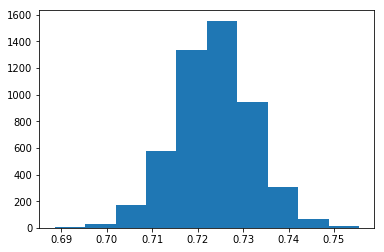

In [2]:
# likelihood score
lk = []
pool = Pool(30)
preds = []
for i in range(B):
    preds.append(pool.apply_async(log_likelihood, (features, targets, outputs[i])))

for pred in preds:
    lk.append(pred.get())

plt.hist(lk)

In [ ]:
# AUC score
auc = []
pool = Pool(30)
preds = []
for i in range(B):
    preds.append(pool.apply_async(unpack_thate_get_outputs, (features, outputs[i])))

for pred in preds:
    auc.append(roc_auc_score(targets, pred.get()))

(array([  4.,   4.,  22.,  38.,  80., 105., 173., 173., 254., 305., 375.,
        500., 581., 666., 702., 514., 303., 153.,  41.,   7.]),
 array([0.76597862, 0.7693112 , 0.77264378, 0.77597636, 0.77930895,
        0.78264153, 0.78597411, 0.78930669, 0.79263927, 0.79597185,
        0.79930444, 0.80263702, 0.8059696 , 0.80930218, 0.81263476,
        0.81596734, 0.81929993, 0.82263251, 0.82596509, 0.82929767,
        0.83263025]),
 <a list of 20 Patch objects>)

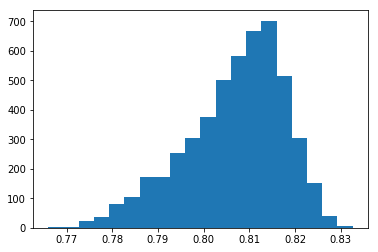

In [5]:
plt.hist(auc, bins=20)

In [ ]:
G = []
pool = Pool(30)
for theta in outputs:
    G.append(gradient(theta))
G = np.array(G)

In [ ]:
feature_name = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']

# 均值
for i in range(X_train.shape[1]):
    plt.title(feature_name[i])
    plt.boxplot(G[:,i])
    plt.show()
    # plt.savefig('box_' + feature_name[i] + '.png')
    plt.close()
    
    plt.title(feature_name[i])
    plt.hist(G[:,i], bins=20)
    # plt.savefig('hist_' + feature_name[i] + '.png')
    plt.show()
    plt.close()



In [ ]:
for i in range(175):
    plt.hist(outputs[:,i], bins=20)
    plt.show()
    plt.close()

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
help(log_loss)